# D-WAVE implementation of the _simplified OneOpto_ optimization model (reduced)

This part is written by Mack. I have yet to able to access the actual quantum computer through LEAP.

Please ensure you are in the correct virtual environment with all the packages installed to continue. Otherwise, the notebook will terminate with a traceback.

## Setup

It is recommended to use a venv (Python virtual environment) to run this notebook to ensure compatibility.
At the time of this submission, Conda and Python 3.13 is not compatible with D-WAVE Ocean.

We will need `dwave-ocean-sdk` for all D-WAVE procedures, and `pandas` with optional dependency `openpyxl` for reading the data file. Running the notebook also requires the `ipykernel` package, which can be automatically downloaded for you.

If the initial check fails, a `ModuleNotFoundError` traceback will generate and execution will stop. If so, please follow the instructions on the next step.

In [1]:
# Packages to import
import dimod
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# Display options
np.set_printoptions(precision=3, linewidth=65536, threshold=65536)
dimod.set_printoptions(width=(1<<20))
CUTOFF = 1000
READS = 65536

# Color format
ENDCOLOR = '\033[0m'
HEADER = '\033[5m\033[1;32m'
YELLOW = '\033[0;33m'
IN = "\033[0;32m"
OUT = "\033[0;31m"
OUT_LOW = '\033[0;31m'
OUT_HIGH = '\033[0;35m'

# Ordinal grades for sorting by letter grade
def ordinalgrade(lettergrade):
    ordinal = lettergrade
    try:
        ordinal = str(["AAA","AA","A","BBB","BB","B","CCC","CC","C","D"].index(lettergrade))
    except ValueError:
        pass
    return ordinal

### Virtual environment

This is for Unix users. On the _dwave subdirectory_, run this command to respectively create and activate the virtual environment. You only have to create the virtual environment once.

### Python packages

Below is the installation for Unix users. Assume we also install all Contributor Ocean tools and auxiliary packages for visualization. We can simply use pip to install the remaining packages.

## Input

We define the data structure using constants, arrays, and the formatting of data organization before converting this into a Python object.

### Data extraction (Part 1)

We extract all the data from the supplied [`/data/1/data_assets_dictionary.xlsx`](/data/1/data_assets_dictionary.xlsx) file relative to this working directory. This requires the `pandas` package.

There are 2628 securities, all listed in USD. Empty values are assigned the `NaN` value.

In [2]:
DATA_ASSETS_DICTIONARY = '../data/1/data_assets_dictionary.xlsx'
df = pd.read_excel(DATA_ASSETS_DICTIONARY, sheet_name=0, header=0)
df

,Unnamed: 0,isin,ccy,assetId,strategyName,secGroup,secType,cpn,posSource,baseCcy,...,Large Issuer_new,issuerTicker_new,sodraw.filterLevel1_new,sodraw.filterLevel3_new,sodraw.filterLevel4_new,security.elements.creditQualityBuckets_new,security.elements.normalizedRating_new,sodraw.filterLevel2_new,assetId_new,main_key
0,0,US001055BJ00,USD,001055BJ0,Unassigned,BND,CORP,3.6,EOD,USD,...,N,AFL,Investment Grade Credit,Insurance,Life Insurance,A,A,Financial,001055BJ0,VCIT | VCIT (bench)
1,1,US001084AS13,USD,001084AS1,Unassigned,BND,CORP,5.8,EOD,USD,...,N,AGCO,Investment Grade Credit,Capital Goods,Construction Machinery,BBB,BBB,Industrial,001084AS1,VCIT | VCIT (bench)
2,2,US00108WAM29,USD,00108WAM2,Unassigned,BND,CORP,2.1,EOD,USD,...,N,AEP,Investment Grade Credit,Electric,Other,BBB,BBB,Utilities,00108WAM2,VCIT | VCIT (bench)
3,3,US00108WAP59,USD,00108WAP5,Unassigned,BND,CORP,4.7,EOD,USD,...,N,AEP,Investment Grade Credit,Electric,Other,BBB,BBB,Utilities,00108WAP5,VCIT | VCIT (bench)
4,4,US00108WAR16,USD,00108WAR1,Unassigned,BND,CORP,5.4,EOD,USD,...,N,AEP,Investment Grade Credit,Electric,Other,BBB,BBB,Utilities,00108WAR1,VCIT | VCIT (bench)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2624,2624,NaN,USD,USD_CCASH,Unassigned,CASH,CASH,0.0,ORD,USD,...,N,USD,NaN,Other,Other,NR,Junk / NR,NaN,USD_CCASH,VCIT | VCIT (bench)
2625,2625,NaN,USD,USD_CCASH,Unassigned,CASH,CASH,0.0,TRD,USD,...,N,USD,NaN,Other,Other,NR,Junk / NR,NaN,USD_CCASH,VCIT | VCIT (bench)
2626,2626,NaN,USD,UXYZ42029,Unassigned,FUTURE,FIN,0.0,EOD,USD,...,N,UXYZ4,NaN,Other,Other,AAA/AA,AAA,NaN,UXYZ42029,VCIT | VCIT (bench)
2627,2627,NaN,USD,UXYZ4202F,Unassigned,CASH,FUTURE,0.0,EOD,USD,...,N,UXYZ4,NaN,Other,Other,AAA/AA,AAA,NaN,UXYZ4202F,VCIT | VCIT (bench)


### Summary

From the dataframe, the sets are:

* $|C| = 2628$
    * A reduced subset containing only 31 elements is also provided.
    * Another reduced subset containing only 12 elements, with none of the ${\mathbb{K}_{\ell}}$ empty will also be tested.
* $L = \{\textrm{AAA}, \textrm{AA}, \textrm{A}, \textrm{BBB}, \textrm{NR}\}$
    * $\textrm{NR}$ encompasses both not rated bonds and speculative bonds.
* $\sum_{\ell \in L} \mathbb{K}_{\ell} = |C|$. Using `security.elements.normalizedRating_new`, we obtain:
    * $|\mathbb{K}_{\textrm{AAA}}| = 7$
    * $|\mathbb{K}_{\textrm{AA}}| = 376$
    * $|\mathbb{K}_{\textrm{A}}| = 863$
    * $|\mathbb{K}_{\textrm{BBB}}| = 1372$
    * $|\mathbb{K}_{\textrm{NR}}| = 11$
* $J$ depends on one of the six test cases. Note that $J \subsetneq F$ where $F$ is the list of all fields. Also, $|F| = 278$.
    * 31-bond, average only and no complex variables
    * 31-bond, average only
    * 31-bond, min-max average
    * 31-bond, original
    * full dataset, reduced
    * full dataset, original
* There are a small number of duplicate entries and pending entries.

Instead, we will use a reduced dataset; also $L$ is divided into industry-rating combinations. Furthermore, all $c$ can be mapped to a unique natural number, call this the canonical ordering.

* $|C| = 31$
* $L = \{\textrm{Capital}, \textrm{Investment}, \textrm{Transportation}\}$
* $J = \{\textrm{PMV}\}$
* $\forall j\,\forall c\,\beta_{j, c} = 1$
* $\forall j\,\rho_{j} = 1$
* $\mathrm{ord}: C \rightarrow [0:|C|)$

### Defining the guardrails (Part 1)

Each security is indexed with an `assetID`. According from the data assets dictionary spreadsheet, it is an "Internal master identifier used by Vanguard systems to join to the firm‑wide security master."

The reduced set is also provided. This has been obtained directly from one of the `.lp` files.

Each element in $L$ would be augmented by two intervals $\vec{K}, \vec{b}$, one for each $j \in J$. Each element in $c$ would also be augmented by a weight $\vec{\beta}$, one for each $j \in J$. A sanity check will be performed to prevent any index-out-of-bounds errors. All of the bounds will be stored in the `KB` triple array.

In [3]:
# Define the reduced set and constants
from types import NoneType
from typing import Union


REDUCED_SET = ["020002BJ9","026874DS3","081437AT2","097023CJ2","13645RAD6","13645RBF0","14448CBC7","15135BAW1","21871XAS8","24422EWZ8","24422EXP9","302491AU9","36166NAK9","438516CM6","443201AC2","444859BR2","444859BV3","444859BY7","444859CA8","45687VAB2","539830CD9","540424AT5","56501RAN6","655844CR7","655844CT3","75513EAD3","759351AP4","760759BA7","760759BC3","907818FX1","91324PEJ7"]
REDUCED_SET_L = []
OTHER_SET = ["00130HCG8","00206RMM1","00287YDT3","00774MAY1","00774MBE4","00914AAK8","010392FU7","015271AU3","020002BJ9","023135CR5","026874DS3","03027XBC3","03027XCH1","03040WBD6","03073EAR6","03073EAU9","031162CW8","031162CZ1","035240AR1","037833DU1","038222AN5","03938LBF0","03938LBG8","04273WAE1","049560AX3","053015AF0","053332BF8","054989AA6","054989AB4","05526DBX2","05964HBG9","06051GJB6","06051GJT7","06051GKA6","06051GLH0","06368L3L8","06406RBB2","06406RBH9","06406RBR7","06406RBU0","06406RBZ9","06418JAC5","06738ECA1","06738ECE3","06738ECG8","071813CB3","0778FPAL3","081437AT2","09247XAT8","09290DAB7","097023CJ2","10112RBE3","10373QBW9","11135FAS0","11135FBH3","12503MAC2","12505BAE0","126650DN7","126650DR8","126650DX5","134429BP3","13645RAD6","13645RBF0","14040HCY9","14448CBC7","15135BAW1","15189WAS9","15189YAH9","166764BY5","17275RBS0","172967ML2","172967NN7","172967PA3","17325FBG2","174610BH7","191216CT5","194162AS2","20030NCU3","20825UAC8","209111GE7","21871XAS8","22003BAM8","22541LAE3","22822VAW1","22822VAY7","22822VBE0","231021AT3","23338VAS5","233835AQ0","24422EWZ8","24422EXP9","25243YBD0","254687FQ4","254687FX9","25468PBW5","254709AT5","25470DBJ7","25746UDL0","260543DC4","260543DJ9","26439XAC7","26441CBH7","26441CBL8","26442UAS3","28368EAE6","29273VAQ3","29278NAQ6","29379VCF8","29444UBU9","29736RAT7","30161NBK6","30225VAK3","30225VAQ0","30231GBN1","30303M8H8","314353AA1","316773DL1","337738BH0","337738BN7","341081GG6","341081GL5","341081GP6","345397B36","36166NAK9","37045XER3","37045XEV4","372460AA3","375558BY8","38141GYB4","38141GYN8","38143VAA7","404119CK3","404121AK1","404280DV8","404280EC9","404280EG0","40434LAC9","431282AU6","437076CF7","437076CJ9","438516CM6","440452AF7","44107TBA3","44107TBB1","443201AC2","444859BR2","444859BV3","444859BY7","444859CA8","456837BH5","45687VAB2","45866FAK0","459200BB6","459200KN0","459200KU4","46590XAP1","46647PBJ4","46647PBL9","46647PDY9","48203RAP9","49271VAJ9","49456BAV3","49456BAX9","50155QAL4","532457CF3","539830CD9","540424AT5","548661DY0","56501RAN6","565849AR7","57636QBB9","58013MFV1","581557BU8","58507LBC2","59523UAW7","606822BU7","606822BX1","606822CX0","60687YBH1","60687YBL2","615369AZ8","6174468X0","61747YEH4","61747YEL5","61747YEU5","61747YFE0","61747YFJ9","637417AS5","637432PA7","637432PC3","64110DAK0","641423CD8","651639AY2","65339KCP3","65473PAJ4","65535HAS8","65535HBA6","65535HBV0","655844CR7","655844CT3","665859AV6","670346AS4","67103HAL1","682680BK8","68389XAV7","68389XBD6","68389XCP8","686330AR2","693475BU8","693506BS5","694308KR7","695114CW6","695114DC9","703481AD3","70450YAL7","713448EZ7","713448FA1","713448FE3","713466AD2","716973AE2","717081EY5","718172CP2","723787AR8","74456QCJ3","74456QCQ7","74456QCS3","744573AX4","745310AK8","747525BP7","74762EAL6","75513EAD3","756109AX2","759351AP4","760759BA7","760759BC3","78016FZQ0","78016HZQ6","78409VAS3","797440BZ6","797440CB8","806854AJ4","808513BS3","808513CA1","816851BR9","824348BT2","828807DW4","83444MAE1","842587DR5","8426EPAG3","8426EPAH1","845011AC9","855244AZ2","855244BH1","857477BG7","862121AD2","863667AY7","86562MCB4","86562MCS7","87264ACV5","87264ADF9","872652AA0","87612GAA9","87971MBW2","89157XAA9","89236TGU3","89788MAP7","89788NAA8","90265EAW0","907818FX1","91159HJG6","91159HJL5","91324PEJ7","91913YAE0","92343VFX7","92343VGJ7","92556HAB3","927804GR9","92940PAG9","931142EY5","95000U2L6","95000U2U6","95000U3H4","958102AR6"]
K_LOW = 0
K_TARGET = 1
K_HIGH = 2
B_LOW = 3
B_HIGH = 4
df_r = df[df['isin'].notnull()]
df_r = df_r[df_r["posSource"] == 'EOD']
# df_r = df_r.sort_values(by=['security.elements.normalizedRating_new'], key=lambda x: ordinalgrade(x)) # [df['assetId'].isin(REDUCED_SET)]

# Input variables
L = ["I_Capital_Goods", "I_Insurance", "I_Transportation"]
J = ["fund_enriched.pmv"]
NL, NU = -2000000000, 2000000000
KB_pmv = [[4.758736462913, 5.803304406912, 6.847872350911, 0, 1000],
        [4.134392251914, 5.178960195913, 6.223528139912, 0, 1000], 
        [0.240014083139, 1.284582027138, 2.329149971137, 0, 1000]] # Each must be size L
KB = [KB_pmv]

N = 31
R = [2.600974180557, 10.435233760548]

# Unused variables
BETA = 1
RHO = 1

# Checks for sanity
if len(KB) != len(J):
    raise Exception("K/B matrix requires {0:d} set of guardrail sets; there are {1:d}".format(len(J), len(KB)))
for jIdx in range(len(KB)):
    if len(KB[jIdx]) != len(L):
        raise Exception("K/B[{2:s}] by characteristic requires {0:d} set of guardrails; there are {1:d}".format(len(L), len(KB[jIdx]), J[jIdx]))
    for lIdx in range(len(KB[jIdx])):
        if len(KB[jIdx][lIdx]) < 5:
            raise Exception("Guardrail information of K/B[{0:s},{1:s}] incomplete.".format(J[jIdx], L[lIdx]))

df_r

,Unnamed: 0,isin,ccy,assetId,strategyName,secGroup,secType,cpn,posSource,baseCcy,...,Large Issuer_new,issuerTicker_new,sodraw.filterLevel1_new,sodraw.filterLevel3_new,sodraw.filterLevel4_new,security.elements.creditQualityBuckets_new,security.elements.normalizedRating_new,sodraw.filterLevel2_new,assetId_new,main_key
0,0,US001055BJ00,USD,001055BJ0,Unassigned,BND,CORP,3.60,EOD,USD,...,N,AFL,Investment Grade Credit,Insurance,Life Insurance,A,A,Financial,001055BJ0,VCIT | VCIT (bench)
1,1,US001084AS13,USD,001084AS1,Unassigned,BND,CORP,5.80,EOD,USD,...,N,AGCO,Investment Grade Credit,Capital Goods,Construction Machinery,BBB,BBB,Industrial,001084AS1,VCIT | VCIT (bench)
2,2,US00108WAM29,USD,00108WAM2,Unassigned,BND,CORP,2.10,EOD,USD,...,N,AEP,Investment Grade Credit,Electric,Other,BBB,BBB,Utilities,00108WAM2,VCIT | VCIT (bench)
3,3,US00108WAP59,USD,00108WAP5,Unassigned,BND,CORP,4.70,EOD,USD,...,N,AEP,Investment Grade Credit,Electric,Other,BBB,BBB,Utilities,00108WAP5,VCIT | VCIT (bench)
4,4,US00108WAR16,USD,00108WAR1,Unassigned,BND,CORP,5.40,EOD,USD,...,N,AEP,Investment Grade Credit,Electric,Other,BBB,BBB,Utilities,00108WAR1,VCIT | VCIT (bench)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2611,2611,US98956PAV40,USD,98956PAV4,Unassigned,BND,CORP,2.60,EOD,USD,...,N,ZBH,Investment Grade Credit,Consumer Non Cyclicals,Health Care,BBB,BBB,Industrial,98956PAV4,VCIT | VCIT (bench)
2612,2612,US98956PAZ53,USD,98956PAZ5,Unassigned,BND,CORP,5.20,EOD,USD,...,N,ZBH,Investment Grade Credit,Consumer Non Cyclicals,Health Care,BBB,BBB,Industrial,98956PAZ5,VCIT | VCIT (bench)
2614,2614,US98971DAB64,USD,98971DAB6,Unassigned,BND,CORP,3.25,EOD,USD,...,N,ZION,Investment Grade Credit,Banking,Other,BBB,BBB,Financial,98971DAB6,VCIT | VCIT (bench)
2616,2616,US98978VAS25,USD,98978VAS2,Unassigned,BND,CORP,2.00,EOD,USD,...,N,ZTS,Investment Grade Credit,Consumer Non Cyclicals,Pharmaceuticals,BBB,BBB,Industrial,98978VAS2,VCIT | VCIT (bench)


## Implementation

We implement the D-WAVE solver provided $C, L, K, b$.

### Defining the data type (Part 2)

We define the data type by assuming types match. Each security $c \in C$ will be converted to a tuple augmented by bucket membership and the betas for each characteristic $j \in J$. $C$ and $\mathbb{K}$ will be implemented as a list, and an `indexmap` will convert the ID to the index in $C$.

In [4]:
CID = 0
MINTRADE = 1
MAXTRADE = 2
INVENTORY = 3
PMV = 4
DXS = 5
DELTA = 6
RATING = 7
BETAS = -1

### Dataframe generation functions

Functions for obtaining the $C$ in this format, and for sorting the elements of $C$ by bucket membership. The $L$ inputted will also generate the $\mathbb{K}$ and the $\mathrm{ord}$ function for converting the bond name into its canonical ordering. Note $\mathbb{K}$ is represented as `KC`, and $\mathrm{ord}$ is represented as `indexmap`.

In [5]:
def generate_from_C(df):
    """ Generate C from the dataframe """
    C = []
    KC = [[],[],[],[],[]]
    indexmap = {}
    count = 0
    for c in df.iterrows():
        _series = c[1]
        _c = (_series['assetId'], 
              _series['minTradeSize'], 2*_series['minTradeSize'], _series['basket.unitSz'], 
              _series['price'], _series['fund_enriched.dxsCtr'], _series['minTradeIncrement'],
              _series['security.elements.normalizedRating_new'], [BETA]*len(J))
        C.append(_c)
        lIdx = 4
        rating = _series["security.elements.normalizedRating_new"]
        if rating == 'AAA':
            lIdx = 0
        elif rating == 'AA':
            lIdx = 1
        elif rating == 'A':
            lIdx = 2
        elif rating == 'BBB':
            lIdx = 3
        print(_c[0], _c[1], _c[2], _c[3], _c[4], _c[5], _c[6], _c[7])

        KC[lIdx].append(_c)

    for lIdx in range(len(L)):
        for c in KC[lIdx]:
            indexmap.update({c[CID]: len(indexmap)})

    return C, KC, indexmap

def generate_from_sample():
    """ Generate C from the sample data """
    # Extract JSON
    _c_json = None
    indexmap = {}
    with open('bond_data1.json', 'r') as f:
        import json
        _c_json = json.loads(f.read())
        del json

    C = []
    KC = [[],[],[],[]]
    count = 0
    for _series in _c_json["bonds"]:
        rating = _series["sector"]
        c = (_series['id'], _series["min"], _series["max"], _series["max"], _series["pmv"], _series["dxs"], 1, rating, [BETA]*len(J))
        
        C.append(c)
        lIdx = 4
        if rating == 'Capital_Goods':
            lIdx = 0
        elif rating == 'Insurance':
            lIdx = 1
        elif rating == 'Transportation':
            lIdx = 2
        else:
            lIdx = 3
        KC[lIdx].append(c)
        count += 1

    for lIdx in range(len(L)):
        for c in KC[lIdx]:
            indexmap.update({c[CID]: len(indexmap)})

    return C, KC, indexmap

df_r = df_r[df_r['assetId'].isin(OTHER_SET)]
C, KC, indexmap = generate_from_sample()
for lIdx in range(len(L)):
    for c in KC[lIdx]:
        print("{0:s}:\t{1:8.3f}\t{2:8.3f} (=)\t{4:8.3f}\t{5:8.3f}\t{6:s}\t".format(c[CID], c[MINTRADE], c[MAXTRADE], c[INVENTORY], c[PMV], c[DXS], c[RATING]), c[DELTA], c[BETAS])
indexmap


081437AT2:	   5.000	  30.000 (=)	   0.029	  13.316	Capital_Goods	 1 [1]
097023CJ2:	   5.000	  13.000 (=)	   0.027	  34.462	Capital_Goods	 1 [1]
14448CBC7:	   5.000	  30.000 (=)	   0.034	  22.473	Capital_Goods	 1 [1]
24422EWZ8:	   5.000	  17.000 (=)	   0.033	   7.419	Capital_Goods	 1 [1]
24422EXP9:	   5.000	  30.000 (=)	   0.033	  16.111	Capital_Goods	 1 [1]
36166NAK9:	   5.000	  30.000 (=)	   0.032	  14.942	Capital_Goods	 1 [1]
438516CM6:	   5.000	  30.000 (=)	   0.032	  13.523	Capital_Goods	 1 [1]
443201AC2:	   5.000	  15.000 (=)	   0.032	  14.155	Capital_Goods	 1 [1]
45687VAB2:	   5.000	   9.000 (=)	   0.034	  20.093	Capital_Goods	 1 [1]
539830CD9:	   5.000	  30.000 (=)	   0.032	  15.855	Capital_Goods	 1 [1]
75513EAD3:	   5.000	  27.000 (=)	   0.028	   9.403	Capital_Goods	 1 [1]
760759BA7:	   5.000	  30.000 (=)	   0.026	  15.388	Capital_Goods	 1 [1]
760759BC3:	   5.000	  30.000 (=)	   0.032	  18.718	Capital_Goods	 1 [1]
020002BJ9:	   5.000	  30.000 (=)	   0.026	  11.747	Insurance	 1 

{'081437AT2': 0,
 '097023CJ2': 1,
 '14448CBC7': 2,
 '24422EWZ8': 3,
 '24422EXP9': 4,
 '36166NAK9': 5,
 '438516CM6': 6,
 '443201AC2': 7,
 '45687VAB2': 8,
 '539830CD9': 9,
 '75513EAD3': 10,
 '760759BA7': 11,
 '760759BC3': 12,
 '020002BJ9': 13,
 '026874DS3': 14,
 '15135BAW1': 15,
 '21871XAS8': 16,
 '444859BR2': 17,
 '444859BV3': 18,
 '444859BY7': 19,
 '444859CA8': 20,
 '540424AT5': 21,
 '56501RAN6': 22,
 '759351AP4': 23,
 '91324PEJ7': 24,
 '13645RAD6': 25,
 '13645RBF0': 26,
 '314353AA1': 27,
 '655844CR7': 28,
 '655844CT3': 29,
 '907818FX1': 30}

### Objective function (Part 2)

We have to minimize an objective function that consists of at least $|C||J|$ terms. Duplicate cases will be merged if $c \in C$ belongs to multiple $\ell \in L$. Each entry therefore consists of a block-matrix QUBO matrix.

[[33.678 26.822  1.65 ]] 62.150121734581425
[-6.261 -3.288 -6.157 -3.962 -6.184 -6.2   -6.203 -3.618 -2.548 -6.195 -5.748 -6.296 -6.195 -5.48  -5.375 -5.454 -5.352 -3.65  -5.358 -5.355 -5.375 -5.418 -5.42  -5.425 -4.062 -0.991 -1.27  -1.893 -0.342 -0.54  -1.521]
[[-6.261  0.123  0.296  0.18   0.285  0.278  0.277  0.159  0.118  0.28   0.225  0.231  0.28   0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.123 -3.288  0.146  0.088  0.14   0.137  0.136  0.078  0.058  0.138  0.111  0.114  0.138  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.296  0.146 -6.157  0.214  0.339  0.331  0.329  0.189  0.14   0.333  0.268  0.275  0.333  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.18   0.088  0.214 -3.962  0.205  0.2    0.199  0.115  0.085  0.202  0.16

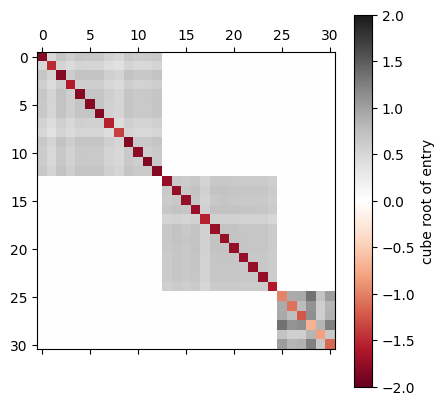

In [6]:
def how_much_bond(c):
    if not c[DELTA]:
        raise Exception("A bond has zero interval.")
    return (c[MINTRADE] + min(c[MAXTRADE], c[INVENTORY]))/(2*c[DELTA])

# Generate QUBO matrix
matrix = np.zeros((len(C), len(C)))
for lIdx in range(len(KC)):
    for jIdx in range(len(J)):
        # Obtain quadratic coefficients, including diagonal terms
        KCl = KC[lIdx]
        for c1 in KCl:
            for c2 in KCl:
                matrix[indexmap[c1[CID]]][indexmap[c2[CID]]] += RHO*BETA*c1[PMV]*how_much_bond(c1)*BETA*c2[PMV]*how_much_bond(c2)
        # Obtain linear coefficients
        for c in KCl:
            matrix[indexmap[c[CID]]][indexmap[c[CID]]] -= RHO*2*KB[jIdx][lIdx][K_TARGET]*BETA*c1[PMV]*how_much_bond(c)

# Consider constant term
constantterm = np.zeros((len(J), len(L)))
for lIdx in range(len(L)):
    for jIdx in range(len(J)):
        constantterm[jIdx][lIdx] = KB[jIdx][lIdx][K_TARGET]*KB[jIdx][lIdx][K_TARGET]

mbar = plt.matshow(np.cbrt(matrix), cmap=mpl.colormaps["RdGy"], vmin=-2, vmax=2)
cbar = plt.colorbar(mbar)
cbar.set_label("cube root of entry")
print(constantterm, np.sum(constantterm))
print(np.diag(matrix))
print(matrix)

## D-WAVE Implementation

After constructing the QUBO, we define the optimization model using the `dimod` package.

### Binary quadratic model (Part 2)

We use the QUBO matrix to define ane name the variables (which will be the IDs), their linear entries, and their quadratic entries.

In [7]:
from dimod import BinaryQuadraticModel

# Convert to binary quadratic model
bqm = BinaryQuadraticModel(vartype=dimod.BINARY)
for i in range(len(C)):
    bqm.add_variable(C[i][CID])
    bqm.add_linear(C[i][CID], matrix[i][i])
for i1 in range(len(C)):
    for i2 in range(i1 + 1, len(C)):
        if matrix[i1][i2]:
            bqm.add_quadratic(C[i1][CID], C[i2][CID], 2*matrix[i1][i2])
        
bqm

BinaryQuadraticModel({'020002BJ9': -6.260929595936642, '026874DS3': -3.2875700503087253, '081437AT2': -6.157097206317578, '097023CJ2': -3.9624176013452677, '13645RAD6': -6.18395995995356, '13645RBF0': -6.199672363030624, '14448CBC7': -6.202745000265599, '15135BAW1': -3.618345189828859, '21871XAS8': -2.5483052903963714, '24422EWZ8': -6.194731472200784, '24422EXP9': -5.747776591682852, '314353AA1': -6.296018034463562, '36166NAK9': -6.195288506138863, '438516CM6': -5.479547047581361, '443201AC2': -5.375014257130327, '444859BR2': -5.4544713649379695, '444859BV3': -5.351650425400236, '444859BY7': -3.6504173104390354, '444859CA8': -5.357542914246724, '45687VAB2': -5.354994429260476, '539830CD9': -5.374607557844501, '540424AT5': -5.4180465555766, '56501RAN6': -5.4196952039639585, '655844CR7': -5.424674366604599, '655844CT3': -4.061647588735684, '75513EAD3': -0.990763284056966, '759351AP4': -1.2704399492733585, '760759BA7': -1.8928466882348047, '760759BC3': -0.3418301928563352, '907818FX1': -0

### Linear inequality constraints (Part 3)

We will implement the linear inequality constraints. There are $2 + 2|J||L|$ linear constraints to consider. The Lagrange multiplier for the global constraints is calculated to enforce the constraints. We have disabled the $b$ bounds.

In [8]:
# Add master linear inequality constraints
sy = []
sx = []
sr = []
for i in range(len(C)):
    sy.append((C[i][CID], 1))
    sx.append((C[i][CID], C[i][PMV]*C[i][DELTA]*how_much_bond(C[i])))

lm = np.sum(abs(matrix), axis=1) # Hard restraint
bqm.add_linear_inequality_constraint(sy, ub = N, lagrange_multiplier=np.dot(lm,lm), label="Sy") # Bonds in basket
bqm.add_linear_inequality_constraint(sx, lb = R[0], ub = R[1], lagrange_multiplier=np.dot(lm,lm), label="Sx") # Residual cash flow

# # Add bucket and characteristic based inequality constraints
for j in range(len(J)):
    for l in range(len(L)):
        if len(KC[l]) == 0:
            continue 
        syl = []
        sxl = []
        for i in range(len(KC[l])):
            # syl.append((KC[l][i][CID], BETA))
            sxl.append((KC[l][i][CID], KC[l][i][PMV]*KC[l][i][DELTA]*BETA*how_much_bond(KC[l][i])))
        print(l, j, KB[j][l])
        # print(syl)
        print(sxl)
        # bqm.add_linear_inequality_constraint(syl, lb = KB[j][l][K_LOW], ub = KB[j][l][K_HIGH], lagrange_multiplier=np.sqrt(np.dot(lm,lm)), label="Sy_{0:s}_{1:s}".format(J[j], L[l]))
        bqm.add_linear_inequality_constraint(sxl, lb = KB[j][l][K_LOW], ub = KB[j][l][K_HIGH], lagrange_multiplier=np.dot(lm,lm), label="Sx_{0:s}_{1:s}".format(J[j], L[l]))

0 0 [4.758736462913, 5.803304406912, 6.847872350911, 0, 1000]
[('081437AT2', 0.498939895055), ('097023CJ2', 0.24568965940499998), ('14448CBC7', 0.5939473112125), ('24422EWZ8', 0.359862572135), ('24422EXP9', 0.57088585099), ('36166NAK9', 0.556954443185), ('438516CM6', 0.554189150515), ('443201AC2', 0.31871754859), ('45687VAB2', 0.235887590876), ('539830CD9', 0.5613725524225), ('75513EAD3', 0.451779939008), ('760759BA7', 0.4624419751175), ('760759BC3', 0.56087619728)]
1 0 [4.134392251914, 5.178960195913, 6.223528139912, 0, 1000]
[('020002BJ9', 0.460848299975), ('026874DS3', 0.5629511044850001), ('15135BAW1', 0.48729543219), ('21871XAS8', 0.5833333333275), ('444859BR2', 0.2999877524915), ('444859BV3', 0.5782605718225), ('444859BY7', 0.580459967535), ('444859CA8', 0.5633122094599999), ('540424AT5', 0.5233370305975), ('56501RAN6', 0.5217595223925), ('759351AP4', 0.5169659916925), ('91324PEJ7', 0.408217997668)]
2 0 [0.240014083139, 1.284582027138, 2.329149971137, 0, 1000]
[('13645RAD6', 1.17

/home/samaria/github/replacement/implementation/ocean/lib/python3.13/site-packages/dimod/binary/binary_quadratic_model.py:773: UserWarning: Did not add constraint Sy. This constraint is feasible with any value for state variables.
  warnings.warn(
/home/samaria/github/replacement/implementation/ocean/lib/python3.13/site-packages/dimod/binary/binary_quadratic_model.py:762: UserWarning: For constraints with fractional coefficients, multiply both sides of the inequality by an appropriate factor of ten to attain or approximate integer coefficients. 
  warnings.warn("For constraints with fractional coefficients, "


## D-WAVE Experiment (Part 4)

We use the D-WAVE sampler to perform quantum annealing. The result will be exported as a CSV file. The process can take three minutes to complete a 65536-reads run across the 31-bonds set.

In [9]:
from dwave.samplers import PathIntegralAnnealingSampler
sampler = PathIntegralAnnealingSampler()
sampleset = sampler.sample(bqm, num_reads=READS)
df_s = sampleset.to_pandas_dataframe().sort_values(by="energy")
df_s.to_csv("dwave_result.csv")
df_s

,020002BJ9,026874DS3,081437AT2,097023CJ2,13645RAD6,13645RBF0,14448CBC7,15135BAW1,21871XAS8,24422EWZ8,...,91324PEJ7,slack_Sx_0,slack_Sx_1,slack_Sx_2,slack_Sx_fund_enriched.pmv_I_Capital_Goods_0,slack_Sx_fund_enriched.pmv_I_Insurance_0,slack_Sx_fund_enriched.pmv_I_Transportation_0,slack_Sx_fund_enriched.pmv_I_Transportation_1,energy,num_occurrences
22481,1,1,1,1,0,0,1,1,1,1,...,0,0,0,0,1,1,1,1,-48.657070,1
46776,1,1,1,1,0,0,1,1,1,1,...,0,0,0,0,1,1,1,1,-48.657070,1
39877,1,1,1,1,0,0,1,1,1,1,...,0,0,0,0,1,1,1,1,-48.448508,1
10108,1,1,1,1,0,0,1,1,1,1,...,0,0,0,0,1,1,1,1,-48.448508,1
33712,1,1,1,1,0,0,1,1,1,1,...,0,0,0,0,1,1,1,1,-48.448508,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62305,1,1,1,1,0,0,1,1,1,0,...,1,0,0,1,1,1,1,1,8255.641676,1
43858,1,1,1,1,0,0,1,1,1,1,...,0,0,0,1,1,1,1,1,8258.053800,1
25477,1,0,1,1,0,0,1,1,1,1,...,1,0,0,1,1,1,1,1,8258.822311,1
27391,0,1,1,1,0,0,0,0,1,1,...,0,0,0,1,1,1,1,1,8266.242608,1


## Sanity Check (Part 5)

Determine the feasibility of each of the solutions. Consider the objective function, the constraints, and whether the feasibility has been satisfied. The results, ranked by D-WAVE energy, will be graphed, along with the shaded region indicating the satisfaction of the constraints.

### Feasibility summary

The five samples with the lowest energy will be summarized to check if any constraints are violated. The structure is of the form:

* Header with D-WAVE energy and selected bonds
    * Global values
        * All bonds
        * Optimization function
        * D-WAVE energy
        * Bonds and Flow
    * Additional bounds
        * Applicable bonds
        * Value against Target

In [10]:
answers = df_s[0:CUTOFF].to_numpy()[:,:len(C)]
totalenergies = df_s[0:CUTOFF].to_numpy()[:,-2]
energies = np.zeros(CUTOFF)
cashflow = np.zeros(CUTOFF)
characteristic = np.zeros((len(L), len(J), CUTOFF))
c_ids = np.array(list(indexmap.keys()))

def _rangecolor_binary(lb, val, ub):
    if val < lb or val > ub:
        return OUT
    return IN

def _rangecolor(lb, val, ub):
    if np.isnan(val):
        return "\033[0;30m"
    if val < lb:
        return OUT_LOW
    if val > ub:
        return OUT_HIGH
    return IN

def _printresult(a_idx, s):
    if a_idx < 5:
        print(s)

for a_idx in range(min(len(answers),CUTOFF)):
    answer = answers[a_idx]
    totalenergy = np.trunc(totalenergies[a_idx]).astype(int)
    ids = c_ids[answer.astype(bool)]
    _printresult(a_idx, f"{HEADER}Solution #1 ({totalenergy}): {ids}{ENDCOLOR}")
    energy = np.dot(answer.T, matrix @ answer) + np.sum(constantterm)
    energies[a_idx] = energy
    bonds = np.dot(np.ones(len(C)), answer).astype(int)

    for c_id in ids:
        c = C[indexmap[c_id]]
        x = how_much_bond(c)
        coeff = c[PMV]*c[DELTA]*how_much_bond(c)
        cashflow[a_idx] += coeff
        _printresult(a_idx, "\t{0:.3f}\t{1:.3f}\t{2:.3f}\t{3:s}".format(x, c[PMV], coeff, str(c)))
    _printresult(a_idx, YELLOW + "\tEnergy:\t{0:.3f}".format(energy) + ENDCOLOR)
    _printresult(a_idx, _rangecolor_binary(0,bonds,N) + "\tBonds:\t{0:d}".format(bonds) + ENDCOLOR)
    _printresult(a_idx, _rangecolor_binary(R[0],cashflow[a_idx],R[1]) + "\tFlow:\t{0:.3f}".format(cashflow[a_idx]) + ENDCOLOR)

    for lIdx in range(len(L)):
        for jIdx in range(len(J)):
            KCl = KC[lIdx]
            for c in KCl:
                if not c[CID] in ids:
                    continue
                x = how_much_bond(c)*(c[CID] in ids)
                kcoeff = c[PMV]*c[DELTA]*c[-1][jIdx]*how_much_bond(c)
                characteristic[lIdx, jIdx, a_idx] += kcoeff
                # bcoeff = c[DXS]/100*c[DELTA]*c[-1][jIdx]*how_much_bond(c)
                # bucketflow += bcoeff
                _printresult(a_idx, "\t\t{0:.3f}\t{1:.3f}\t{2:.3f}\t{3:s}".format(x, c[PMV], kcoeff, str(c)))
            k_diff = characteristic[lIdx, jIdx, a_idx] - KB[jIdx][lIdx][K_TARGET]
            _printresult(a_idx, _rangecolor(KB[jIdx][lIdx][K_LOW], characteristic[lIdx, jIdx, a_idx], KB[jIdx][lIdx][K_HIGH]) 
                         + "\t\tBonds[{1:s}][{2:s}]: Σ={0:.3f} Δ={6:.3f} Δ²={7:.3f} ({3:.3f}, {4:.3f}, {5:.3f})"
                         .format(characteristic[lIdx, jIdx, a_idx], L[lIdx], J[jIdx], 
                                 KB[jIdx][lIdx][K_LOW], KB[jIdx][lIdx][K_TARGET], KB[jIdx][lIdx][K_HIGH],
                                 k_diff, k_diff*k_diff) + ENDCOLOR)
            # _printresult(a_idx, _rangecolor(KB[jIdx][lIdx][B_LOW], bucketflow, KB[jIdx][lIdx][B_HIGH]) 
            #       + "\tFlow[{1:s}][{2:s}]:  {0:.3f} ({3:.3f}, {4:.3f})".format(
            #           bucketflow, L[lIdx], J[jIdx], KB[jIdx][lIdx][B_LOW], KB[jIdx][lIdx][B_HIGH]) + ENDCOLOR)
    _printresult(a_idx, "")

Solution #1 (-48): ['081437AT2' '097023CJ2' '14448CBC7' '24422EWZ8' '438516CM6' '443201AC2' '45687VAB2' '539830CD9' '75513EAD3' '760759BC3' '020002BJ9' '026874DS3' '15135BAW1' '21871XAS8' '444859BR2' '444859BV3' '444859BY7' '444859CA8' '56501RAN6' '91324PEJ7' '13645RBF0' '314353AA1']
	17.500	0.026	0.461	('020002BJ9', 5.0, 30.0, 30.0, 0.02633418857, 11.747405182296, 1, 'Insurance', [1])
	17.500	0.032	0.563	('026874DS3', 5.0, 30.0, 30.0, 0.032168634542, 19.306390960602, 1, 'Insurance', [1])
	17.500	0.029	0.499	('081437AT2', 5.0, 30.0, 30.0, 0.028510851146, 13.316192340035, 1, 'Capital_Goods', [1])
	9.000	0.027	0.246	('097023CJ2', 5.0, 13.0, 13.0, 0.027298851045, 34.461503917596, 1, 'Capital_Goods', [1])
	17.500	0.034	0.594	('14448CBC7', 5.0, 30.0, 30.0, 0.033939846355, 22.473301347308, 1, 'Capital_Goods', [1])
	17.500	0.028	0.487	('15135BAW1', 5.0, 30.0, 30.0, 0.027845453268, 21.626486622322, 1, 'Insurance', [1])
	17.500	0.033	0.583	('21871XAS8', 5.0, 30.0, 30.0, 0.033333333333, 26.97530

### Ranking and visualization of bond allocation

The top graph represent the total energy of the ranked samples. The middle graph contains information about the bonds used (blue) and the cashflow (magenta). The bottom represents the selection of the securities, ordered by index, with filled indicating the security is selected.

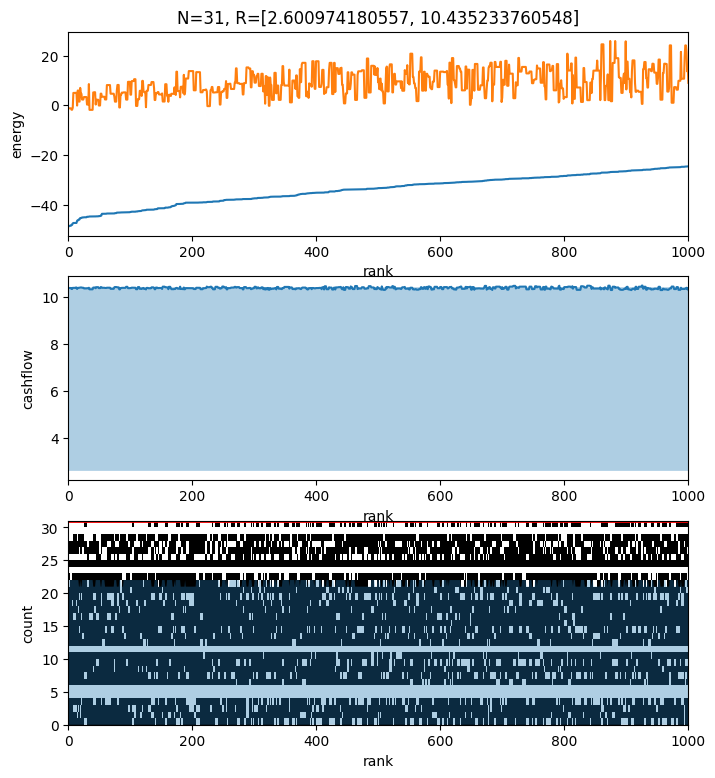

In [11]:
T = np.linspace(0, CUTOFF, CUTOFF)

fig = plt.subplots(3,1, figsize=(8, 9))

plt.subplot(3,1,1)
plt.title("N={0:d}, R={1:s}".format(N, str(R)))
plt.plot(np.linspace(0, CUTOFF, CUTOFF), totalenergies)
plt.plot(np.linspace(0, CUTOFF, CUTOFF), energies)
plt.gca().set(xlim=(0,CUTOFF), xlabel="rank")
plt.gca().set(ylabel="energy")

plt.subplot(3,1,2)
plt.plot(np.linspace(0, CUTOFF, CUTOFF), cashflow)
plt.gca().fill_between(np.linspace(0, CUTOFF, CUTOFF), R[1], R[0], alpha=0.36)
plt.gca().set(xlim=(0,CUTOFF), xlabel="rank")
plt.gca().set(ylabel="cashflow")

plt.subplot(3,1,3)
plt.pcolormesh(answers.transpose(), cmap=mpl.colormaps["Greys"])
plt.gca().plot(T, N*np.ones(CUTOFF), c='r', linewidth=2)
plt.gca().fill_between(np.linspace(0, CUTOFF, CUTOFF), answers.sum(axis=1), alpha=0.36)
plt.gca().set(xlim=(0,CUTOFF), xlabel="rank")
plt.gca().set(ylabel="count")

plt.show()

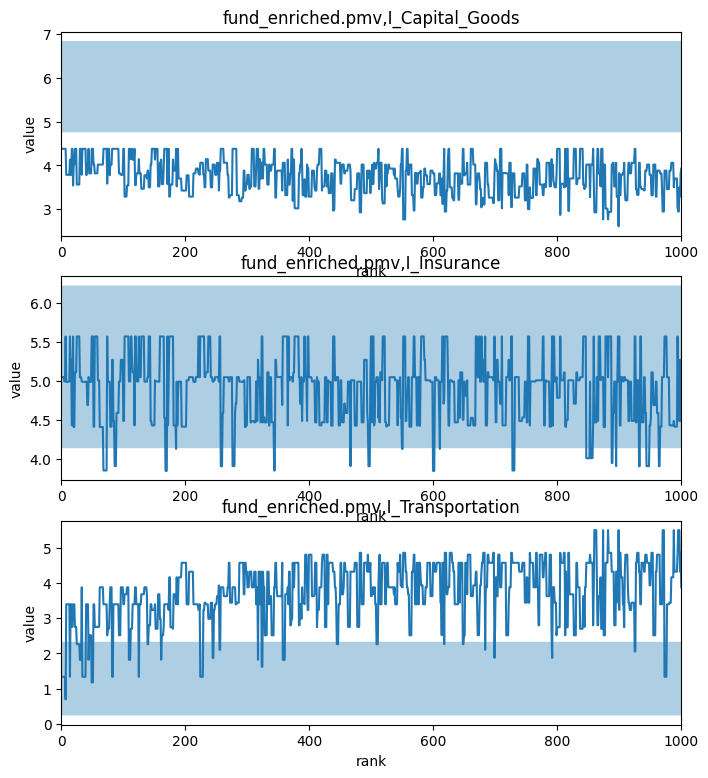

In [12]:
fig = plt.subplots(len(L), len(J), figsize=(8, 9))
for lIdx in range(len(L)):
    for jIdx in range(len(J)):
        plt.subplot(len(L), len(J), 1 + len(J)*lIdx + jIdx)
        plt.title("{0:s},{1:s}".format(J[jIdx], L[lIdx]))
        plt.plot(T, characteristic[lIdx, jIdx])
        plt.gca().fill_between(T, KB[jIdx][lIdx][K_HIGH], KB[jIdx][lIdx][K_LOW], alpha=.36)
        plt.gca().set(xlim=(0,CUTOFF), xlabel="rank")
        plt.gca().set(ylabel="value")

plt.show()

# Full implementation

This is an object-oriented rendition of the code demo, to allow multiple runs in succession. See `implementation.py`.